In [1]:
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats, sparse as sp
from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from BorutaShap import BorutaShap
import category_encoders as ce
import shap

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

TARGET = 'target'

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## EDA

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7000,0.2000,0.7181,10,1,-1,0,1,4,1,0,0,1,12,2,0.4000,0.8837,0.3708,3.6056,0.6000,0.5000,0.2000,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8000,0.4000,0.7661,11,1,-1,0,-1,11,1,1,2,1,19,3,0.3162,0.6188,0.3887,2.4495,0.3000,0.1000,0.3000,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0000,0.0000,-1.0000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.3162,0.6416,0.3473,3.3166,0.5000,0.7000,0.1000,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9000,0.2000,0.5809,7,1,0,0,1,11,1,1,3,1,104,1,0.3742,0.5429,0.2950,2.0000,0.6000,0.9000,0.1000,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7000,0.6000,0.8408,11,1,-1,0,-1,14,1,1,2,1,82,3,0.3161,0.5658,0.3651,2.0000,0.4000,0.6000,0.0000,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
train, test = check_duplicates_and_constants(train, test)

Initial train shape: (595212, 59)
Initial test shape: (892816, 58)
Duplicates in train: 0
Duplicates in test: 0
Final train shape: (595212, 59) , test shape: (892816, 58).


In [6]:
equal_columns = []
for col1, col2 in combinations(train.columns[2:], r=2):
    if np.all(train[col1] == train[col2]):
        print(f"{col1} and {col2} are equal")

In [7]:
check_missings(train)

Total NA-values = 0


""
Total
Percent
Types


In [8]:
check_missings(test)

Total NA-values = 0


""
Total
Percent
Types


<AxesSubplot:>

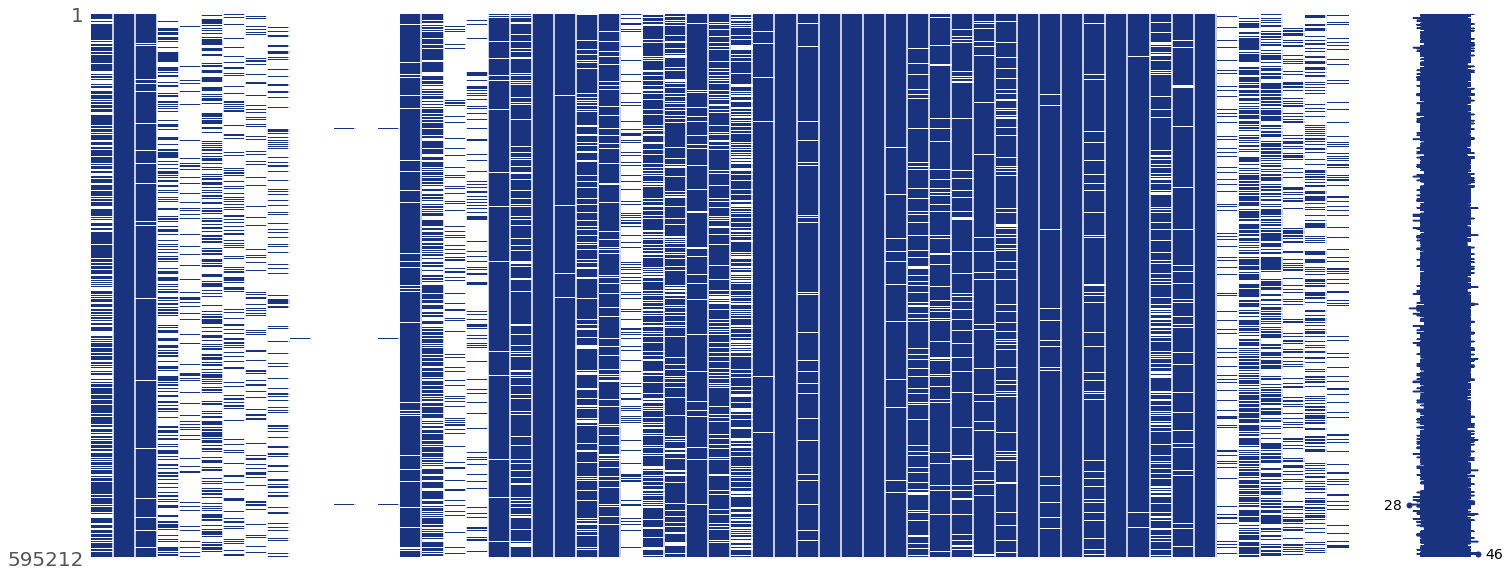

In [9]:
msno.matrix(train.drop(["id", TARGET], axis=1).replace(0, np.nan), color=(0.1, 0.2, 0.5))

In [10]:
train.select_dtypes("object").columns

Index([], dtype='object')

In [11]:
train[TARGET].value_counts(normalize=True)

0   0.9636
1   0.0364
Name: target, dtype: float64

In [12]:
train["id"].nunique() == len(train), test["id"].nunique() == len(test)

(True, True)

In [4]:
binary_columns = []
for column in train.columns[2:]:
    if train[column].nunique() < 3:
        binary_columns.append(column)
print("Binary columns count:", len(binary_columns))

Binary columns count: 18


In [5]:
low_cardinality_columns = []
for column in train.columns[2:]:
    n = train[column].nunique()
    if n > 2 and n <= 20:
        low_cardinality_columns.append(column)
print("Low cardinality columns count:", len(low_cardinality_columns))

Low cardinality columns count: 32


In [6]:
high_cardinality_columns = []
for column in train.columns[2:]:
    n = train[column].nunique()
    if n > 20:
        high_cardinality_columns.append(column)
print("Low cardinality columns count:", len(high_cardinality_columns))

Low cardinality columns count: 7


In [16]:
check_split_equality(train.drop(["id", TARGET], axis=1), test.drop("id", axis=1))

CV-score: 0.5004


In [17]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000,595212.0000
mean,743803.5584,0.0364,1.9004,1.3589,4.4233,0.4168,0.4052,0.3937,0.2570,0.1639,0.1853,0.0004,0.0017,0.0094,0.0009,0.0125,7.2999,0.6608,0.1211,0.1534,0.6110,0.4392,0.5511,8.2959,0.8299,-0.5049,0.7252,-0.1577,6.5553,0.9100,0.8321,1.3289,0.9921,62.2157,2.3461,0.3799,0.8133,0.2763,3.0659,0.4498,0.4496,0.4498,2.3721,1.8859,7.6894,3.0058,9.2259,2.3390,8.4336,5.4414,1.4419,2.8723,7.5390,0.1224,0.6278,0.5542,0.2872,0.3490,0.1533
std,429367.8204,0.1874,1.9838,0.6646,2.6999,0.4933,1.3506,0.4886,0.4370,0.3702,0.3885,0.0193,0.0411,0.0967,0.0308,0.1275,3.5460,0.4734,0.3262,0.3604,0.2876,0.4043,0.7935,2.5083,0.3757,0.7887,2.1535,0.8444,5.5014,0.3471,0.3738,0.9787,0.0916,33.0125,0.8325,0.0583,0.2246,0.3572,0.7314,0.2872,0.2869,0.2872,1.1172,1.1349,1.3343,1.4146,1.4597,1.2469,2.9046,2.3329,1.2030,1.6949,2.7467,0.3278,0.4834,0.4971,0.4524,0.4767,0.3603
min,7.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.0000,-1.0000,0.0000,-1.0000,0.0000,-1.0000,0.0000,1.0000,-1.0000,-1.0000,0.2506,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,371991.5000,0.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.4000,0.2000,0.5250,7.0000,1.0000,-1.0000,0.0000,-1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,32.0000,2.0000,0.3162,0.6709,0.3332,2.8284,0.2000,0.2000,0.2000,2.0000,1.0000,7.0000,2.0000,8.0000,1.0000,6.0000,4.0000,1.0000,2.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,743547.5000,0.0000,1.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.0000,1.0000,0.0000,0.0000,0.7000,0.3000,0.7207,7.0000,1.0000,-1.0000,0.0000,0.0000,7.0000,1.0000,1.0000,2.0000,1.0000,65.0000,3.0000,0.3742,0.7658,0.3688,3.3166,0.5000,0.4000,0.5000,2.0000,2.0000,8.0000,3.0000,9.0000,2.0000,8.0000,5.0000,1.0000,3.0000,7.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000
75%,1115548.7500,0.0000,3.0000,2.0000,6.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1.0000,0.0000,0.0000,0.9000,0.6000,1.0000,11.0000,1.0000,0.0000,0.0000,1.0000,11.0000,1.0000,1.0000,2.0000,1.0000,93.0000,3.0000,0.4000,0.9062,0.3965,3.6056,0.7000,0.7000,0.7000,3.0000,3.0000,9.0000,4.0000,10.0000,3.0000,10.0000,7.0000,2.0000,4.0000,9.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
max,

In [18]:
scores = calculate_feature_separating_ability(train.drop(["id", TARGET], axis=1), train[TARGET])
explore = scores[scores > 0.05]

**ps_car_11**

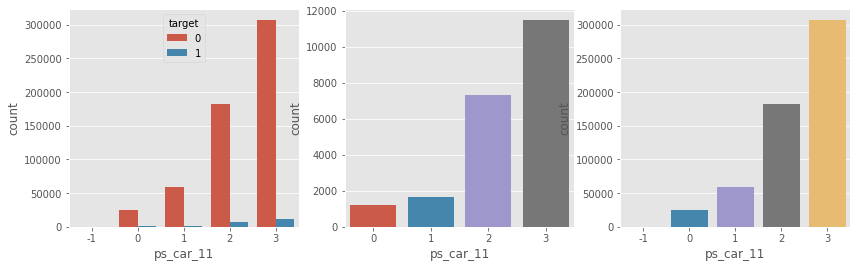

In [19]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
sns.countplot("ps_car_11", hue=TARGET, data=train)
plt.subplot(132)
sns.countplot("ps_car_11", data=train[train[TARGET] == 1])
plt.subplot(133)
sns.countplot("ps_car_11", data=train[train[TARGET] == 0])
plt.show()

In [20]:
stats.chi2_contingency(pd.crosstab(train["ps_car_11"], train[TARGET]))[1]

3.590305412153178e-54

**ps_reg_03**

In [21]:
train["ps_reg_03"].value_counts().head()

-1.0000    107772
0.6339        664
0.6026        637
0.7049        627
0.5879        616
Name: ps_reg_03, dtype: int64

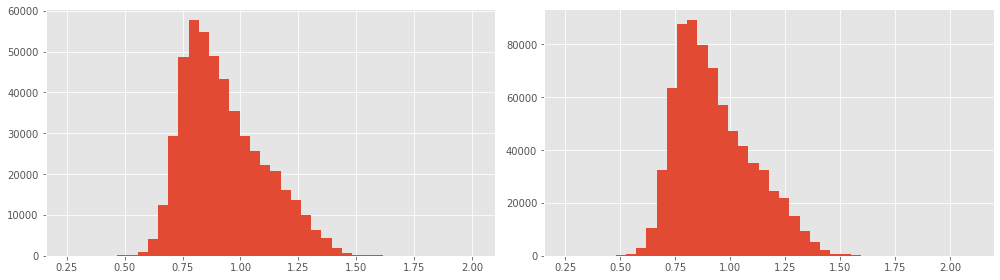

In [22]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.hist(train.loc[train.ps_reg_03 != -1, 'ps_reg_03'].map(np.sqrt), bins=40)
plt.subplot(122)
plt.hist(test.loc[test.ps_reg_03 != -1, 'ps_reg_03'].map(np.sqrt), bins=40)
plt.tight_layout()
plt.show()

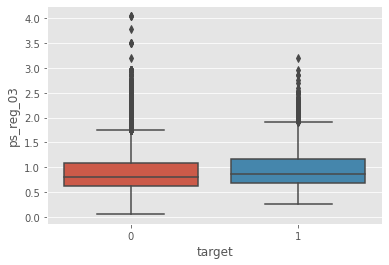

In [23]:
sns.boxplot(y="ps_reg_03", x=TARGET, data=train[train["ps_reg_03"] != -1])
plt.show()

**ps_car_12**

<AxesSubplot:>

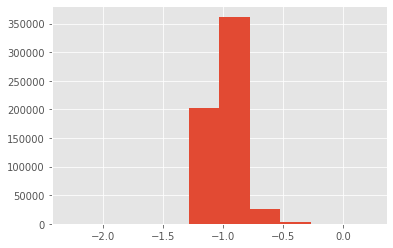

In [24]:
train.loc[train["ps_car_12"] != -1, "ps_car_12"].apply(np.log).hist()

<AxesSubplot:xlabel='target', ylabel='ps_car_12'>

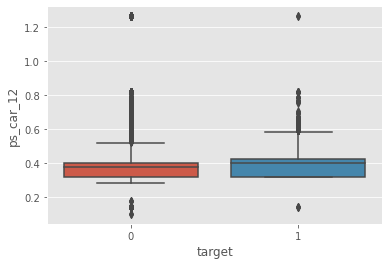

In [25]:
sns.boxplot(y="ps_car_12", x=TARGET, data=train[train["ps_car_12"]!=-1])

**ps_car_14**

In [26]:
train["ps_car_14"].value_counts()

-1.0000    42620
0.3615     17696
0.3583     15523
0.3619     11885
0.3688     11626
           ...  
0.5268         1
0.2131         1
0.6033         1
0.4115         1
0.5114         1
Name: ps_car_14, Length: 850, dtype: int64

<AxesSubplot:>

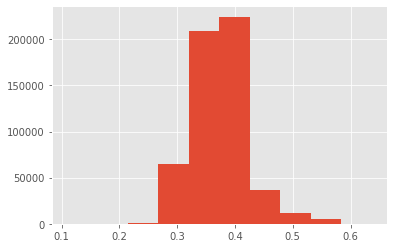

In [27]:
train.loc[train["ps_car_14"] != -1, "ps_car_14"].hist()

**ps_car_11**

In [28]:
train["ps_car_11"].value_counts()

 3    318919
 2    189353
 1     60952
 0     25983
-1         5
Name: ps_car_11, dtype: int64

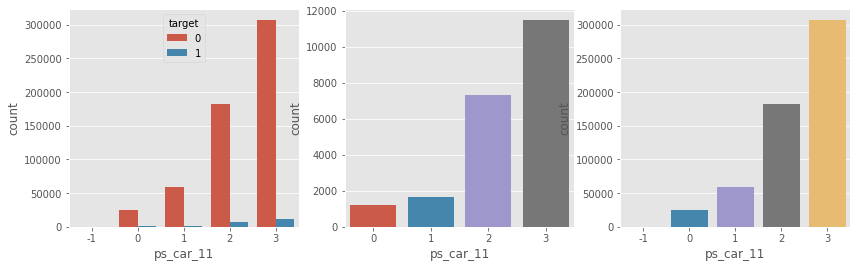

In [29]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
sns.countplot("ps_car_11", hue=TARGET, data=train)
plt.subplot(132)
sns.countplot("ps_car_11", data=train[train[TARGET] == 1])
plt.subplot(133)
sns.countplot("ps_car_11", data=train[train[TARGET] == 0])
plt.show()

### Baseline

In [30]:
lgbm_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'learning_rate': 0.005134,
                'num_leaves': 54,  # 15
                'max_depth': 5,  # 3, 10
                'subsample_for_bin': 240000,  # 300000
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 200,  # 10
                'max_bin': 20
}

In [31]:
x_train, x_test, y_train, y_test = train_test_split(train.drop(["id", TARGET], axis=1), train[TARGET], test_size=0.6,
                                                    random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=seed)

In [32]:
baseline = LGBMClassifier(**lgbm_params).fit(x_train, y_train, 
                                             eval_metric="auc", 
                                             eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                             early_stopping_rounds=50,
                                             verbose=-1)

In [33]:
train_probs = baseline.predict_proba(x_train)[:,1]
test_probs = baseline.predict_proba(x_test)[:,1]

report(y_train, train_probs>=0.5, y_test, test_probs>=0.5, train_probs, test_probs)
gini_normalized(y_test, test_probs)

Train
               precision    recall  f1-score   support

           0     0.9641    1.0000    0.9817    229533
           1     0.0000    0.0000    0.0000      8551

    accuracy                         0.9641    238084
   macro avg     0.4820    0.5000    0.4909    238084
weighted avg     0.9295    0.9641    0.9465    238084

Test
               precision    recall  f1-score   support

           0     0.9632    1.0000    0.9813    171997
           1     0.0000    0.0000    0.0000      6567

    accuracy                         0.9632    178564
   macro avg     0.4816    0.5000    0.4906    178564
weighted avg     0.9278    0.9632    0.9452    178564

Train ROC_AUC: 0.694, Test ROC_AUC: 0.644
Train GINI: 0.388, Test GINI: 0.287


0.2870098903448264

In [34]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, test_probs, gini_normalized))

(0.27324820643470843, 0.3009612733633738)

In [ ]:
sub_preds = baseline.predict_proba(test.drop("id", axis=1))[:,1]  # 0.27186 private, 0.26809 not in CI
submission = pd.DataFrame(data={"ID": test["id"], TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f submission.csv -m "Message"

## FE

In [7]:
df = pd.concat([train, test])
del train, test; gc.collect()

0

In [8]:
df["ps_reg_03_sqrt"] = np.nan
df.loc[df["ps_reg_03"] != -1, "ps_reg_03_sqrt"] = df.loc[df["ps_reg_03"] != -1, 'ps_reg_03'].map(np.sqrt)

df["ps_car_14_sqrt"] = np.nan
df.loc[df["ps_car_14"] != -1, "ps_car_14_sqrt"] = df.loc[df["ps_car_14"] != -1, 'ps_car_14'].map(np.sqrt)

df["bin_sum"] = df[binary_columns].sum(axis=1)
df["bin_mean"] = df[binary_columns].mean(axis=1)
df["bin_std"] = df[binary_columns].std(axis=1)

df["nans"] = (df == -1).sum(axis=1).astype(float)
df[high_cardinality_columns] = df[high_cardinality_columns].replace(-1, np.nan)

In [9]:
train, test = df[~df[TARGET].isna()], df[df[TARGET].isna()]
del df; gc.collect()

0

In [10]:
cat_features = [c for c in train.columns if "cat" in c]
ind_features = [c for c in train.columns if "ind" in c]

In [11]:
aggs = { 
    "ps_car_13": ["mean", "max", "min", "std"],
    "ps_reg_03_sqrt": ["mean", "max", "min", "std"],
    "ps_car_12": ["mean", "max", "min", "std"],
    "ps_reg_02": ["mean", "max", "min"]
}

df_agg = create_numerical_aggs(data=train, groupby_id="ps_car_03_cat", aggs=aggs, suffix="_by_ps_car_03_cat")
train = train.merge(df_agg, on="ps_car_03_cat", how="left")
test = test.merge(df_agg, on="ps_car_03_cat", how="left")

df_agg = create_numerical_aggs(data=train, groupby_id="ps_car_04_cat", aggs=aggs, suffix="_by_ps_car_04_cat")
train = train.merge(df_agg, on="ps_car_04_cat", how="left")
test = test.merge(df_agg, on="ps_car_04_cat", how="left")

In [12]:
for count, column in enumerate(ind_features):
    if count == 0:
        train["ind_total"] = train[column].astype(str) + '_'
        test["ind_total"] = test[column].astype(str) + '_'
    else:
        train["ind_total"] += train[column].astype(str) + '_'
        test["ind_total"] += test[column].astype(str) + '_'
        
train["ind_total"] = train["ind_total"].astype("category")
test["ind_total"] = test["ind_total"].astype("category")

In [13]:
for column in cat_features + ["ind_total"]:
    d = train[column].value_counts().to_dict()
    train[f"{column}_count"] = train[column].apply(lambda x: d.get(x, 0))
    test[f"{column}_count"] = test[column].apply(lambda x: d.get(x, 0))

In [14]:
train, y = train.drop(["id", TARGET], axis=1), train[TARGET].values
test_index = test["id"]
test = test.drop("id", axis=1)

In [15]:
for col in cat_features[:-1]:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

enc = OneHotEncoder()  # make gbm overfit with ohe features to apply ensemble afterall
X_cat = enc.fit_transform(train[cat_features])
X_test_cat = enc.transform(test[cat_features])

In [16]:
train_features = [feat for feat in train.columns if feat not in cat_features + ["ind_total"]]

In [17]:
train_list = [train[train_features].values, X_cat]
test_list = [test[train_features].values, X_test_cat]

X = sp.hstack(train_list).tocsr()
X_test = sp.hstack(test_list).tocsr()

## Model selection

In [25]:
lgbm_params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.010245749525828544,
                'num_leaves': 42, 
                'max_depth': -1, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.0024766,
                'subsample': 0.9,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 25,
                'min_child_weight': 181.09772834960552,
                'max_bin': 256
}

params = {
          "objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": 0.1,
          "num_leaves": 15,
          "max_bin": 256,
          "feature_fraction": 0.6,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

**blending**

In [30]:
fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

lgbm_estimators, oof_scores = lightgbm_cross_validation(lgbm_params, X[:, perm_ind], y, cv=fold, verbose=-1)

Fri Sep 23 23:34:30 2022, Cross-Validation, 595212 rows, 69 cols
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[853]	valid_0's binary_logloss: 0.15112	valid_0's gini: 0.301488
Fold 1, Train score = 0.37630, Valid score = 0.30149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's binary_logloss: 0.151539	valid_0's gini: 0.29179
Fold 2, Train score = 0.37365, Valid score = 0.29179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[997]	valid_0's binary_logloss: 0.151439	valid_0's gini: 0.297583
Fold 3, Train score = 0.38700, Valid score = 0.29758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[740]	valid_0's binary_logloss: 0.152045	valid_0's gini: 0.27246
Fold 4, Train score = 0.36909, Valid score = 0.27246
Training until validation scores don't improve for 100 rounds
Early stoppi

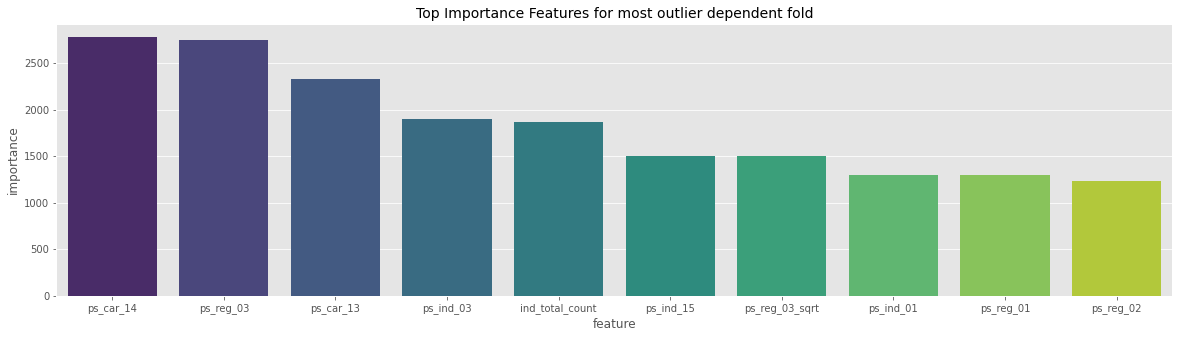

In [82]:
importances = lgbm_estimators[3].feature_importance()
cols = train[train_features].columns.tolist() + [f"cat_feat_{i}" for i in range(X_cat.shape[1])]
cols = np.array(cols)[perm_ind]

importance = pd.DataFrame({
    "feature": cols,
    "importance": importances
})
importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top Importance Features for most outlier dependent fold", size=14)
plt.show()

In [83]:
train[(np.abs(y - oof_scores) >= 0.99)][importance.feature[:10].tolist()]

,ps_car_14,ps_reg_03,ps_car_13,ps_ind_03,ind_total_count,ps_ind_15,ps_reg_03_sqrt,ps_ind_01,ps_reg_01,ps_reg_02
76397,0.3814,NaN,0.7254,7,91,9,NaN,2,0.1000,0.1000
98386,0.3987,NaN,0.5693,2,577,9,NaN,0,0.3000,0.2000
251235,0.3507,NaN,0.5890,4,105,9,NaN,2,0.1000,0.2000
298707,0.3703,0.5755,0.5600,4,115,11,0.7586,3,0.9000,0.3000
311360,0.3421,NaN,0.6446,2,455,9,NaN,1,0.1000,0.2000
322937,0.3473,NaN,0.6104,3,400,10,NaN,0,0.1000,0.2000
420096,0.4307,NaN,0.7412,9,270,13,NaN,1,0.1000,0.2000
492268,0.3665,NaN,0.5328,8,316,11,NaN,1,0.1000,0.1000
528601,0.3688,NaN,0.6961,2,577,9,NaN,0,0.1000,0.2000
575690,0.3814,NaN,0.7176,3,67,10,NaN,0,0.1000,0.2000


In [34]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores, Gini))

(0.2792719745947711, 0.29448216698969415)

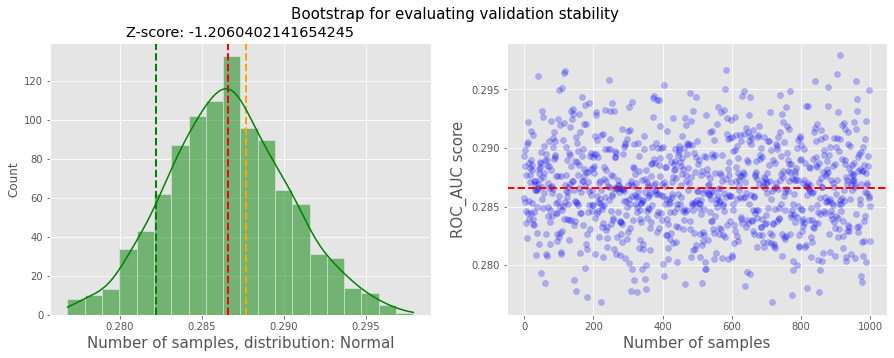

In [38]:
stability = create_bootstrap_metrics(y, oof_scores, Gini)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
axes[0].axvline(0.28770, lw=2, ls='--', c='orange')
axes[0].set_title(f"Z-score: {(0.28220 - np.mean(stability)) / np.std(stability)}") # <= 3sigma
axes[0].axvline(0.28220, lw=2, ls='--', c='green')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [33]:
test_preds = np.array([model.predict(X_test[:, perm_ind], num_iteration=model.best_iteration) for model in lgbm_estimators]).T
test_preds = stats.gmean(test_preds, axis=1)  # 0.28770, 0.28220
pd.DataFrame({'id': test_index, 'target': test_preds}).to_csv('submission.csv', index=False) 
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f submission.csv -m "Message"

Successfully submitted to Porto Seguro’s Safe Driver Prediction



  0%|          | 0.00/24.4M [00:00<?, ?B/s]
  1%|          | 248k/24.4M [00:00<00:16, 1.57MB/s]
  6%|6         | 1.47M/24.4M [00:00<00:03, 6.79MB/s]
  9%|9         | 2.24M/24.4M [00:01<00:14, 1.64MB/s]
 12%|#1        | 2.90M/24.4M [00:01<00:10, 2.23MB/s]
 15%|#4        | 3.57M/24.4M [00:01<00:07, 2.90MB/s]
 18%|#7        | 4.27M/24.4M [00:01<00:05, 3.63MB/s]
 20%|##        | 4.90M/24.4M [00:01<00:05, 3.95MB/s]
 23%|##3       | 5.62M/24.4M [00:01<00:04, 4.70MB/s]
 26%|##6       | 6.38M/24.4M [00:01<00:03, 5.42MB/s]
 29%|##9       | 7.12M/24.4M [00:01<00:03, 5.98MB/s]
 32%|###2      | 7.90M/24.4M [00:02<00:02, 6.50MB/s]
 36%|###5      | 8.71M/24.4M [00:02<00:02, 7.03MB/s]
 39%|###9      | 9.52M/24.4M [00:02<00:02, 7.41MB/s]
 43%|####2     | 10.4M/24.4M [00:02<00:01, 7.75MB/s]
 46%|####6     | 11.3M/24.4M [00:02<00:01, 7.96MB/s]
 50%|####9     | 12.2M/24.4M [00:02<00:01, 8.26MB/s]
 54%|#####3    | 13.1M/24.4M [00:02<00:01, 8.51MB/s]
 58%|#####7    | 14.0M/24.4M [00:02<00:01, 8.79MB/s]
 6

In [60]:
# 0.28599
pd.DataFrame({'id': test_index, 'target': lgbm_estimators[0].predict(X_test[:, perm_ind], num_iteration=lgbm_estimators[0].best_iteration)}).to_csv('submission.csv', index=False) 
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f submission.csv -m "Message"

Successfully submitted to Porto Seguro’s Safe Driver Prediction



  0%|          | 0.00/24.4M [00:00<?, ?B/s]
  1%|          | 240k/24.4M [00:00<00:14, 1.78MB/s]
  8%|7         | 1.90M/24.4M [00:00<00:06, 3.68MB/s]
 21%|##        | 5.07M/24.4M [00:00<00:02, 9.99MB/s]
 32%|###1      | 7.70M/24.4M [00:00<00:01, 14.1MB/s]
 42%|####2     | 10.4M/24.4M [00:00<00:00, 17.5MB/s]
 54%|#####3    | 13.1M/24.4M [00:00<00:00, 20.3MB/s]
 72%|#######2  | 17.7M/24.4M [00:01<00:00, 27.2MB/s]
 85%|########4 | 20.6M/24.4M [00:01<00:00, 26.7MB/s]
 96%|#########6| 23.4M/24.4M [00:01<00:00, 27.4MB/s]
100%|##########| 24.4M/24.4M [00:02<00:00, 8.81MB/s]


In [69]:
N = 16
test_preds = np.zeros((X_test.shape[0], N))

for i in range(N):
    params["random_state"] = seed + i
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed+i)

    lgbm_estimators, oof_scores = lightgbm_cross_validation(lgbm_params, X[:, perm_ind], y, cv=fold, verbose=-1)
    running_scores = np.array([model.predict(X_test[:, perm_ind]) for model in lgbm_estimators]).T
    test_preds[:, i] = stats.gmean(running_scores, axis=1)  # gmean/amean

# test_preds /= N
test_preds = stats.gmean(test_preds, axis=1)
gc.collect()

Sat Sep 24 00:29:28 2022, Cross-Validation, 595212 rows, 69 cols
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[764]	valid_0's binary_logloss: 0.151403	valid_0's gini: 0.294243
Fold 1, Train score = 0.37645, Valid score = 0.29424
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[608]	valid_0's binary_logloss: 0.15182	valid_0's gini: 0.283235
Fold 2, Train score = 0.36361, Valid score = 0.28323
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.15169	valid_0's gini: 0.28485
Fold 3, Train score = 0.37741, Valid score = 0.28485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[939]	valid_0's binary_logloss: 0.151609	valid_0's gini: 0.290097
Fold 4, Train score = 0.39053, Valid score = 0.29010
Training until validation scores don't improve for 100 rounds
Early stoppi

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[860]	valid_0's binary_logloss: 0.151585	valid_0's gini: 0.290835
Fold 5, Train score = 0.38407, Valid score = 0.29084
Train score by each fold: [0.39589, 0.39011, 0.37135, 0.3678, 0.38407]
Valid score by each fold: [0.27971, 0.27752, 0.28392, 0.29647, 0.29084]
Train mean score by each fold:0.38184 +/- 0.01075
Valid mean score by each fold:0.28569 +/- 0.00705
**************************************************
OOF-score: 0.28560
Sat Sep 24 00:54:37 2022, Cross-Validation, 595212 rows, 69 cols
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's binary_logloss: 0.152255	valid_0's gini: 0.271186
Fold 1, Train score = 0.37387, Valid score = 0.27119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[781]	valid_0's binary_logloss: 0.151542	valid_0's gini: 0.290036
Fold 2, Train score = 0.377

Fold 2, Train score = 0.39383, Valid score = 0.29431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[850]	valid_0's binary_logloss: 0.151841	valid_0's gini: 0.284795
Fold 3, Train score = 0.38601, Valid score = 0.28480
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[814]	valid_0's binary_logloss: 0.151603	valid_0's gini: 0.291008
Fold 4, Train score = 0.37999, Valid score = 0.29101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0's binary_logloss: 0.151596	valid_0's gini: 0.283464
Fold 5, Train score = 0.38220, Valid score = 0.28346
Train score by each fold: [0.37741, 0.39383, 0.38601, 0.37999, 0.3822]
Valid score by each fold: [0.27324, 0.29431, 0.2848, 0.29101, 0.28346]
Train mean score by each fold:0.38389 +/- 0.00572
Valid mean score by each fold:0.28536 +/- 0.00725
**************************************************
OOF-sc

1460

In [70]:
pd.DataFrame({'id': test_index, 'target': test_preds}).to_csv('submission.csv', index=False)  # 0.28788 private, 0.28236
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f submission.csv -m "Message"

Successfully submitted to Porto Seguro’s Safe Driver Prediction



  0%|          | 0.00/24.4M [00:00<?, ?B/s]
  1%|          | 232k/24.4M [00:00<00:16, 1.56MB/s]
  8%|7         | 1.91M/24.4M [00:00<00:06, 3.59MB/s]
 21%|##1       | 5.17M/24.4M [00:00<00:02, 9.95MB/s]
 29%|##9       | 7.12M/24.4M [00:00<00:01, 12.0MB/s]
 46%|####5     | 11.1M/24.4M [00:00<00:00, 18.8MB/s]
 56%|#####5    | 13.6M/24.4M [00:01<00:00, 20.0MB/s]
 65%|######5   | 15.9M/24.4M [00:01<00:00, 21.0MB/s]
 75%|#######4  | 18.3M/24.4M [00:01<00:00, 21.5MB/s]
 86%|########5 | 20.9M/24.4M [00:01<00:00, 22.4MB/s]
 96%|#########6| 23.4M/24.4M [00:01<00:00, 23.2MB/s]
100%|##########| 24.4M/24.4M [00:02<00:00, 9.15MB/s]


### Feature Selection

In [18]:
data = pd.DataFrame(data=X.toarray(), columns=train_features + [f"cat_{i+1}" for i in range(184)])
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.6, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=seed)

In [21]:
estimator = LGBMClassifier(**lgbm_params).fit(x_train, y_train, 
                                              eval_metric="auc", 
                                              eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                              early_stopping_rounds=50,
                                              verbose=-1)

scores, deltas = calculate_permutation_importance(estimator, 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

deltas = deltas[deltas > 0].index.tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [04:14<00:00,  1.09it/s]


In [22]:
perm_ind = [i for i, col in enumerate(data.columns) if col in deltas]

### Parameters tunning

In [23]:
start_params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'max_depth': -1, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.0024766,
                'subsample': 0.9,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'max_bin': 256
}


def objective(trial):
    param_trials = {
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 96),
                    'min_child_samples': trial.suggest_int('min_child_samples', 2, 300),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 200)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 X[:, perm_ind], 
                                                 y, 
                                                 cv=fold, 
                                                 rounds=100,
                                                 verbose=False)
    
    return score

In [24]:
%%time
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-23 17:54:29,415] A new study created in memory with name: no-name-e3aa555d-db22-44d2-95a3-2b83d4475362
[I 2022-09-23 17:55:03,456] Trial 0 finished with value: 0.27744800000000003 and parameters: {'learning_rate': 0.11423841529766665, 'num_leaves': 92, 'min_child_samples': 220, 'min_child_weight': 119.73209818092313}. Best is trial 0 with value: 0.27744800000000003.
[I 2022-09-23 17:56:16,301] Trial 1 finished with value: 0.28448399999999996 and parameters: {'learning_rate': 0.049337536211403646, 'num_leaves': 20, 'min_child_samples': 19, 'min_child_weight': 173.23536297884127}. Best is trial 1 with value: 0.28448399999999996.
[I 2022-09-23 17:56:51,226] Trial 2 finished with value: 0.27574200000000004 and parameters: {'learning_rate': 0.18153115848773302, 'num_leaves': 70, 'min_child_samples': 8, 'min_child_weight': 193.9820005225467}. Best is trial 1 with value: 0.28448399999999996.
[I 2022-09-23 17:57:19,217] Trial 3 finished with value: 0.27534800000000004 and parameters

[I 2022-09-23 18:48:40,589] Trial 31 finished with value: 0.285466 and parameters: {'learning_rate': 0.010245749525828544, 'num_leaves': 42, 'min_child_samples': 25, 'min_child_weight': 181.09772834960552}. Best is trial 31 with value: 0.285466.
[I 2022-09-23 18:50:10,922] Trial 32 finished with value: 0.2848 and parameters: {'learning_rate': 0.028240581370412656, 'num_leaves': 31, 'min_child_samples': 27, 'min_child_weight': 181.2318116282801}. Best is trial 31 with value: 0.285466.
[I 2022-09-23 18:51:02,291] Trial 33 finished with value: 0.282686 and parameters: {'learning_rate': 0.062135520257287025, 'num_leaves': 42, 'min_child_samples': 77, 'min_child_weight': 169.80090759856716}. Best is trial 31 with value: 0.285466.
[I 2022-09-23 18:52:18,169] Trial 34 finished with value: 0.28500800000000004 and parameters: {'learning_rate': 0.0372366619361738, 'num_leaves': 33, 'min_child_samples': 24, 'min_child_weight': 188.6738821496567}. Best is trial 31 with value: 0.285466.
[I 2022-09-

Number of completed trials: 62
Best trial
Best score: 0.285466
Best params
{'learning_rate': 0.010245749525828544,
 'min_child_samples': 25,
 'min_child_weight': 181.09772834960552,
 'num_leaves': 42}
CPU times: total: 1d 19h 55min 54s
Wall time: 2h 48min 1s
